**Importing the Libraries**

In [1]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

**Loading the Dataset**

In [2]:
train = [line.strip() for line in open("../data/raw/train.txt", "r").readlines()[1:]]
raw_x_train = [line.split("\t")[1] for line in train]
raw_y_train = [line.split("\t")[0] for line in train]

test = [line.strip() for line in open("../data/raw/test.txt", "r").readlines()]
raw_x_test = [line.split("\t")[1] for line in test]
raw_y_test = [line.split("\t")[0] for line in test]

val=[line.strip() for line in open("../data/raw/val.txt", "r").readlines()]
raw_x_val=[line.split("\t")[1] for line in val]
raw_y_val=[line.split("\t")[0] for line in val]


**Tokenizing the Dataset**

In [3]:
tokenizer = Tokenizer(lower=True, char_level=True, oov_token='-n-')
tokenizer.fit_on_texts(raw_x_train + raw_x_val + raw_x_test)
char_index = tokenizer.word_index
sequence_length=200
x_train = pad_sequences(tokenizer.texts_to_sequences(raw_x_train), maxlen=sequence_length)
x_val = pad_sequences(tokenizer.texts_to_sequences(raw_x_val), maxlen=sequence_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(raw_x_test), maxlen=sequence_length)

encoder = LabelEncoder()

y_train = encoder.fit_transform(raw_y_train)
y_val = encoder.transform(raw_y_val)
y_test = encoder.transform(raw_y_test)

**Parameters**

In [4]:
params = {'loss_function': 'binary_crossentropy',
                       'optimizer': 'adam',
                       'sequence_length': 200,
                       'batch_train': 5000,
                       'batch_test': 5000,
                       'categories': ['phishing', 'legitimate'],
                       'char_index': None,
                       'epoch': 30,
                       'embedding_dimension': 50,
                       'dataset_dir': "../dataset/small_dataset/"}

**Model Definition**

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
model = Sequential()
voc_size = len(char_index.keys())
print("voc_size: {}".format(voc_size))
model.add(Embedding(voc_size + 1, 50))

model.add(Conv1D(128, 3, activation='tanh'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))

model.add(Conv1D(128, 7, activation='tanh', padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5, activation='tanh', padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 3, activation='tanh', padding='same'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5, activation='tanh', padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 3, activation='tanh', padding='same'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))

model.add(Conv1D(128, 3, activation='tanh', padding='same'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(len(params['categories'])-1, activation='sigmoid'))



voc_size: 71


**Training**

In [7]:
model.compile(loss=params['loss_function'], optimizer=params['optimizer'], metrics=['accuracy'])


hist = model.fit(x_train, y_train,
                batch_size=params['batch_train'],
                epochs=params['epoch'],
                shuffle=True,
                validation_data=(x_val, y_val)
                )


Epoch 1/30
 22/210 ━━━━━━━━━━━━━━━━━━━━ 11:55 4s/step - accuracy: 0.5704 - loss: 0.6743

KeyboardInterrupt: 

**Prediction**

In [7]:
y_pred = model.predict(x_test, batch_size=1000)
print(y_pred)



365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step
[[3.0322914e-04]
 [9.9987245e-01]
 [9.9953967e-01]
 ...
 [2.5733060e-04]
 [9.9827147e-01]
 [9.9795902e-01]]


**Prediction**

In [8]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

# Convert predicted probabilities to binary labels
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
y_test=y_test.reshape(-1,1)

# Calculate classification report
report = classification_report(y_test, y_pred_binary)
print('Classification Report:')
print(report)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_binary)
print('Confusion Matrix:', confusion_mat)
print('Accuracy:',accuracy_score(y_test,y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    201736
           1       0.99      0.97      0.98    162463

    accuracy                           0.98    364199
   macro avg       0.98      0.98      0.98    364199
weighted avg       0.98      0.98      0.98    364199

Confusion Matrix: [[200168   1568]
 [  5320 157143]]
Accuracy: 0.9810872627327367


**Confusion Matrix **

<Axes: >

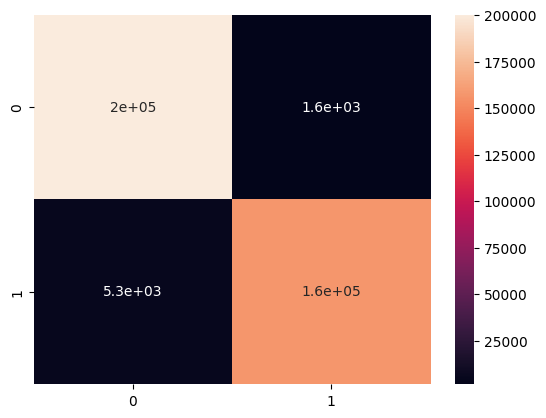

In [9]:
import seaborn as sns
sns.heatmap(confusion_mat,annot=True)